## Epipolar Geometry

If we take photos with one pin-hole camera, it is hard to make them look like 3-D. Because it loses depth information. But we can make up it by using 2 cameras or even more to take photos. Let's look at what a same point varies its location in different views.
![img1](./ipyimg/epipolar.jpg)
As we can see, for one picture taken by the left camera alone, we find that the location of one point in the picture can be on one place in a line. When we project the line to the photo taken by the right camear, there will be a line that we call as **epiline**. So for one point in image left, we only try to math one point in a line at the right image, instead of the whole plane of the right image. We call this **Epipolar Constraint**. The two centers of 2 cameras are **$O'$** and **$O$** . And the 2 projection points are **$e$** and **$e'$** .The 2 projection points are called **Epipole**s. If the relative location of the 2 camera are fixed, epipoles will fix there location in the images. So apart from meature the location manully, we can find two epilines, and the intersection point is the epipole.<br>
So we need to focus on finding epipolar lines and epipoles. But we also have to fing **Fundamental Matrix(F)** or **Essential Matrix(E)**. They contains information about translation adn rotation. Just as the image below shows.
![img2](./ipyimg/essential_matrix.jpg)
We prefer to use **F**, because Fundamental Matrix contains more information than Essential Matrix, like focal lengths and so on. If we are using rectified images and normalize the point by dividing by the focal lengths, there will be F=E.

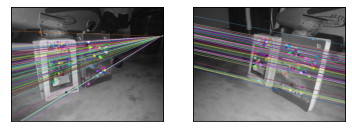

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import glob
%matplotlib inline

img1 = cv.imread('../img/left.jpg', 0)
img2 = cv.imread('../img/right.jpg', 0)

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE,
                    trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Find Fundamental Matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

# select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1, img2, lines, pts1, pts2):

    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)

    return img1, img2

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img3), plt.xticks([]), plt.yticks([])

plt.show()
